In [1]:
# Exercise Apply k-NN on Amazon reviews dataset

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot.metrics as skplt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler


from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hemant\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\hemant\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:

# using the SQLite Table to read data.
con = sqlite3.connect(r'G:\machine_learning\Real_world_problem_Predict_rating_given_product_reviews_on_Amazon\amazon\database1.sqlite')
 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,good,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'it', "wasn't", 'now', 'until', 'other', 'than', 'couldn', 'yourselves', "you've", 'here', 'below', 'why', 'ain', 'when', 'mightn', 'won', "should've", "hasn't", 'herself', "shan't", 'that', 'few', 'only', 'a', 'can', 'will', 'on', 'being', 'its', 'because', 'to', "won't", 'after', 'each', 'your', "you're", 'itself', 'as', 'did', 'in', 'himself', 'down', 'nor', 'off', 'very', 'the', 'his', 'weren', 'mustn', 'needn', "isn't", 'this', 'you', 'again', 'we', 'what', 'were', 'some', 'myself', "haven't", 'my', 's', 'should', 'don', 'these', 'not', 'further', 'by', 'both', 'yours', 'theirs', 'then', 'out', 'where', 'is', 'with', 'there', 'they', 'do', "hadn't", 'for', 'wouldn', 'd', 'be', 'or', 'same', 'against', 'been', 'shan', "shouldn't", "don't", 'shouldn', "doesn't", 'me', 'wasn', 'ours', 'all', 'more', 'was', "couldn't", "weren't", 'themselves', 'her', 'and', 'of', 'from', 've', 'before', 'y', 'most', 'haven', "aren't", 'just', "wouldn't", "needn't", "you'd", 'but', 'having', 'didn', '

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# function to find optimal k from knn with kd-tree algorithm

In [15]:
# kd_tree algo 

def find_optimal_k_kdtree(x_tr_dataset,y_train,x_cv_dataset,y_cv):
    from sklearn.metrics import f1_score
    
    #Setup arrays to store training and test accuracies
    neighbors = np.arange(1,9)
 #   train_accuracy =np.empty(len(neighbors))
    acc = np.empty(len(neighbors))
    error = np.empty(len(neighbors))
    for i,k in enumerate(neighbors):
        
    # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree' )

    # fitting the model on crossvalidation train
        knn.fit(x_tr_dataset, y_train)

    # predict the response on the crossvalidation train
        pred = knn.predict(x_cv_dataset)

    # evaluate CV accuracy
        acc[i] = f1_score(y_cv, pred, average='macro') * float(100)
        #print('\nCV accuracy for k = %d is %d%%' % (i, acc))
        error[i] = 100-acc[i]
           
  #  optimal_k = int(min(error))
  #  print('\nThe optimal number of neighbors is %d.' % optimal_k)

    
    #Generate plot
    d = acc.max()
    i = np.where(acc == d)
    optimal_k = int(neighbors[i])
    print("optimal_k is:-",optimal_k)
    plt.title('k-NN Varying number of neighbors')
    plt.plot(neighbors, error, label='Testing Accuracy')
#plt.plot(neighbors, train_accuracy, label='Training accuracy')
    plt.legend()
    plt.xlabel('Number of neighbors')
    plt.ylabel('Misclassification error')
    plt.grid()
    plt.show()
    
    return optimal_k

# function to find optimal k from knn with brute algorithm

In [16]:
# brute algo 

def find_optimal_k_brute(x_tr_dataset,y_train,x_cv_dataset,y_cv):
    
    from sklearn.metrics import f1_score
    
    #Setup arrays to store training and test accuracies
    neighbors = np.arange(1,9)
 #   train_accuracy =np.empty(len(neighbors))
    acc = np.empty(len(neighbors))
    error = np.empty(len(neighbors))
    for i,k in enumerate(neighbors):
        
    # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute' )

    # fitting the model on crossvalidation train
        knn.fit(x_tr_dataset, y_train)

    # predict the response on the crossvalidation train
        pred = knn.predict(x_cv_dataset)

    # evaluate CV accuracy
        acc[i] = f1_score(y_cv, pred, average='macro') * float(100)
        #print('\nCV accuracy for k = %d is %d%%' % (i, acc))
        error[i] = 100-acc[i]
           
  #  optimal_k = int(min(error))
  #  print('\nThe optimal number of neighbors is %d.' % optimal_k)

    
    #Generate plot
    d = acc.max()
    i = np.where(acc == d)
    optimal_k = int(neighbors[i])
    print("optimal_k is:-",optimal_k)
    plt.title('k-NN Varying number of neighbors')
    plt.plot(neighbors, error, label='Testing Accuracy')
#plt.plot(neighbors, train_accuracy, label='Training accuracy')
    plt.legend()
    plt.xlabel('Number of neighbors')
    plt.ylabel('Misclassification error')
    plt.grid()
    plt.show()
    
    return optimal_k

# randomly generate data and sort in ascending order

In [17]:
#random_sample = final.sample(n = 6000)
#random_sample.shape
#random_sample = random_sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_sample = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')    
sample_60000 = sorted_sample.iloc[0:25000]
sample_60000.shape
y = sample_60000['Score']

In [18]:
# sort the data in 60:20:20 ratio
x_train_size = int(len(sample_60000)*.60)
y_size  = int(len(y)*.60)

# split into Train and Test sets    
x_train = sample_60000[0:x_train_size]
x_test = sample_60000[x_train_size:len(sample_60000)]

print("total data",len(sample_60000))
print("x_train data",len(x_train))
#print("x_test data",len(x_test))

y_train = y[0:y_size]
y_test = y[y_size:len(y)]


print("total output data",len(y))
print("total y_train data",len(y_train))
#print("total y_test data",len(y_test))

x_tr_size = int(len(x_test)*.50)
y_tr_size = int(len(y_test)*.50)

x_cv = x_test[0:x_tr_size]
x_ts = x_test[x_tr_size:len(x_test)]

#print("total data",x_tr_size)
print("x_cv data",len(x_cv))
print("x_ts data",len(x_ts))

y_cv = y[0:y_tr_size]
y_ts = y[y_tr_size:len(y_test)]

#print("total data",y_tr_size)
print("y_cv data",len(y_cv))
print("y_ts data",len(y_ts))




total data 25000
x_train data 15000
total output data 25000
total y_train data 15000
x_cv data 5000
x_ts data 5000
y_cv data 5000
y_ts data 5000


In [19]:
# data dimension reduction 
def truncatesvd_reduction(c):
    from sklearn import decomposition
    truncatesd = decomposition.TruncatedSVD()
    truncatesd.n_components = 784
    svd_data = truncatesd.fit_transform(c)

    percentage_var_explained = truncatesd.explained_variance_ratio_ / truncatesd.explained_variance_ratio_.sum()

    cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
    plt.figure(1, figsize=(6, 4))

    plt.clf()
    plt.plot(cum_var_explained, linewidth=2)
    plt.axis('tight')
    plt.grid()
    plt.xlabel('n_components')
    plt.ylabel('Cumulative_explained_variance')
    plt.show()


# [7.2.2] Bag of Words (BoW)

In [19]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
x_tr_final_counts = count_vect.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts = count_vect.transform(x_cv['CleanedText'].values)
x_ts_final_counts = count_vect.transform(x_ts['CleanedText'].values)


print("the type of count vectorizer ",type(x_tr_final_counts))
print("the shape of out text BOW vectorizer ",x_tr_final_counts.get_shape())
print("the number of unique words ", x_tr_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts))
print("the shape of out text BOW vectorizer ",x_cv_final_counts.get_shape())
print("the number of unique words ", x_cv_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts))
print("the shape of out text BOW vectorizer ",x_ts_final_counts.get_shape())
print("the number of unique words ", x_ts_final_counts.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (15000, 16311)
the number of unique words  16311
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 16311)
the number of unique words  16311
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 16311)
the number of unique words  16311


C:\Users\hemant\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hemant\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


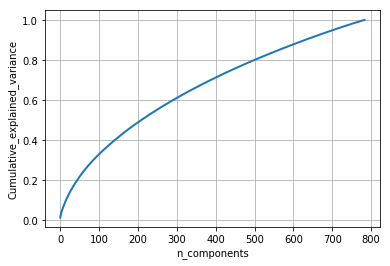

In [20]:
# dimenstionality reduction for bowT train data
sc = StandardScaler(with_mean=False)
c = sc.fit_transform(x_tr_final_counts)
truncatesvd_reduction(c)


Here 500 components explain 80% of the variation in bowT train data

In [21]:
svd = TruncatedSVD(n_components=500)
x_tr_dataset = svd.fit_transform(c)
x_tr_dataset.shape

(15000, 500)

C:\Users\hemant\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hemant\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


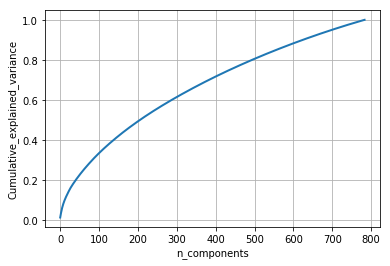

In [22]:
# dimenstionality reduction for bowT cross validation data
c = sc.fit_transform(x_cv_final_counts)
truncatesvd_reduction(c)


Here 500 components explain 80% of the variation in bowT cross validated data

In [23]:
svd = TruncatedSVD(n_components=500)
x_cv_dataset = svd.fit_transform(c)
x_cv_dataset.shape

(5000, 500)

C:\Users\hemant\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hemant\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


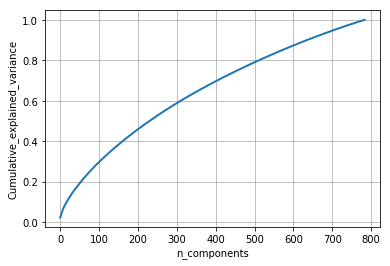

In [24]:
# dimenstionality reduction for bowT test data
c = sc.fit_transform(x_ts_final_counts)
truncatesvd_reduction(c)


Here 500 components explain 80% of the variation in bowT test data

In [25]:
svd = TruncatedSVD(n_components=500)
x_ts_dataset = svd.fit_transform(c)
x_ts_dataset.shape

(5000, 500)

In [26]:
print(x_tr_dataset.shape)
print(x_cv_dataset.shape)
print(x_ts_dataset.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_ts.shape)

(15000, 500)
(5000, 500)
(5000, 500)
(15000,)
(5000,)
(5000,)


optimal_k is:- 2


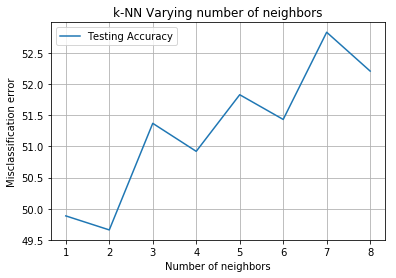

In [27]:
# Finding Optimal K by simple Cross validation by kd- tree algo 

optimal_k = find_optimal_k_kdtree(x_tr_dataset,y_train,x_cv_dataset,y_cv)

In [28]:
from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

#knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)
knn_optimal = KNeighborsClassifier(n_neighbors = 2)

# fitting the model
knn_optimal.fit(x_tr_dataset, y_train)


# predict the response
pred = knn_optimal.predict(x_ts_dataset)

# evaluate f1_score
f1_bowt_kdtree_optimal_k = optimal_k 
f1_bowt_kdtree = f1_score(y_ts, pred, average='macro') * float(100)
print('\nThe f1_score of the knn classifier of KDtree algo for k = %d is %f%%' % (optimal_k, f1_bowt_kdtree))


The f1_score of the knn classifier of KDtree algo for k = 2 is 50.761934%


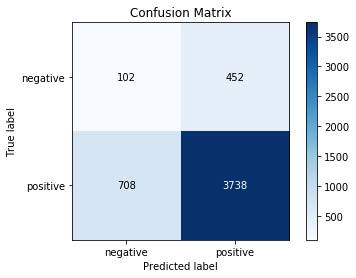

In [29]:
skplt.plot_confusion_matrix(y_ts ,pred)


In [30]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.13      0.18      0.15       554
   positive       0.89      0.84      0.87      4446

avg / total       0.81      0.77      0.79      5000



optimal_k is:- 2


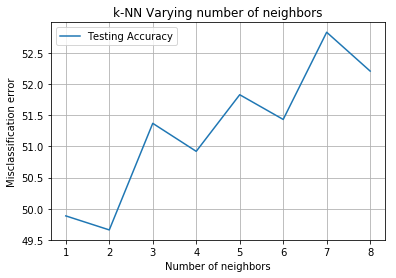

In [31]:
# Finding Optimal K by simple Cross validation by brute algo 

optimal_k = find_optimal_k_brute(x_tr_dataset ,y_train,x_cv_dataset,y_cv)


In [32]:
from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)

# fitting the model
knn_optimal.fit(x_tr_dataset, y_train)

# predict the response
pred = knn_optimal.predict(x_ts_dataset)

# evaluate f1_score
f1_bowt_brute_optimal_k = optimal_k 

f1_bowt_brute = f1_score(y_ts, pred, average='macro') * float(100)
print('\nThe accuracy of the knn classifier of brute algo for k = %d is %f%%' % (optimal_k, f1_bowt_brute))


The accuracy of the knn classifier of brute algo for k = 2 is 50.761934%


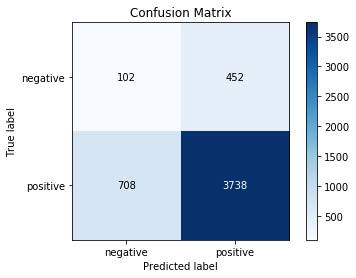

In [33]:
skplt.plot_confusion_matrix(y_ts ,pred)

In [34]:
#classification report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.13      0.18      0.15       554
   positive       0.89      0.84      0.87      4446

avg / total       0.81      0.77      0.79      5000



# [7.2.5] TF-IDF

In [20]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_final_counts = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts = tf_idf_vect.fit_transform(x_cv['CleanedText'].values)
x_ts_final_counts = tf_idf_vect.fit_transform(x_ts['CleanedText'].values)

print("the type of count vectorizer ",type(x_tr_final_counts))
print("the shape of out text TFIDF vectorizer ",x_tr_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_tr_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts))
print("the shape of out text TFIDF vectorizer ",x_cv_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_cv_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts))
print("the shape of out text TFIDF vectorizer ",x_ts_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_ts_final_counts.get_shape()[1])




the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (15000, 299891)
the number of unique words including both unigrams and bigrams  299891
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 116881)
the number of unique words including both unigrams and bigrams  116881
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 113417)
the number of unique words including both unigrams and bigrams  113417


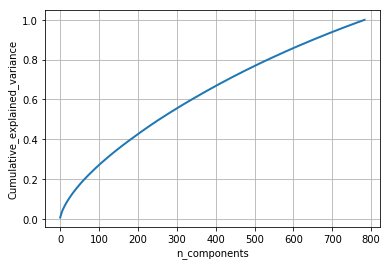

In [22]:
# dimenstionality reduction for TF-IDF train data
sc = StandardScaler(with_mean=False)
c = sc.fit_transform(x_tr_final_counts)
truncatesvd_reduction(c)


Here 500 components explain 80% of the variation in TF-IDF train data

In [23]:
svd = TruncatedSVD(n_components=500)
x_tr_dataset = svd.fit_transform(c)
x_tr_dataset.shape

(15000, 500)

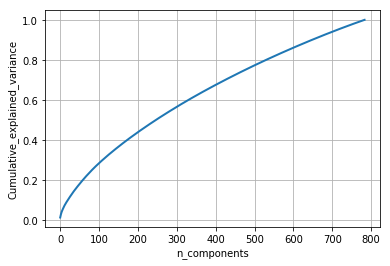

In [24]:
# dimenstionality reduction for TF-IDF cross validate data
c = sc.fit_transform(x_cv_final_counts)
truncatesvd_reduction(c)


Here 500 components explain 80% of the variation in TF-IDF cross validate data

In [25]:
svd = TruncatedSVD(n_components=500)
x_cv_dataset = svd.fit_transform(c)
x_cv_dataset.shape

(5000, 500)

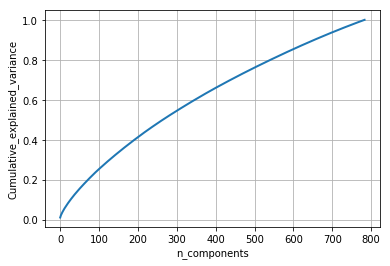

In [26]:
# dimenstionality reduction for TF-IDF test data
c = sc.fit_transform(x_ts_final_counts)
truncatesvd_reduction(c)


Here 500 components explain 80% of the variation in TF-IDF test data

In [27]:
svd = TruncatedSVD(n_components=500)
x_ts_dataset = svd.fit_transform(c)
x_ts_dataset.shape

(5000, 500)

In [28]:
print(x_tr_dataset.shape)
print(x_cv_dataset.shape)
print(x_ts_dataset.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_ts.shape)

(15000, 500)
(5000, 500)
(5000, 500)
(15000,)
(5000,)
(5000,)


optimal_k is:- 1


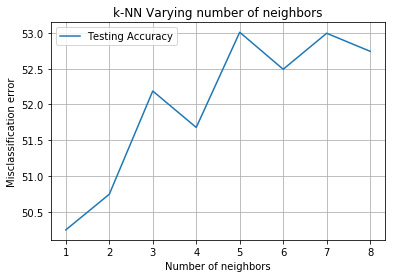

In [29]:
# Finding Optimal K by simple Cross validation by kd- tree algo 


optimal_k = find_optimal_k_kdtree(x_tr_dataset,y_train,x_cv_dataset,y_cv)

In [30]:
from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)

# fitting the model
knn_optimal.fit(x_tr_dataset, y_train)

# predict the response
pred = knn_optimal.predict(x_ts_dataset)

# evaluate f1_score
f1_tfidf_kdtree_optimal_k = optimal_k
f1_tfidf_kdtree = f1_score(y_ts, pred, average='macro') * float(100)
print('\nThe f1_score of the knn classifier of KDtree algo for k = %d is %f%%' % (optimal_k, f1_tfidf_kdtree))




The f1_score of the knn classifier of KDtree algo for k = 1 is 51.053416%


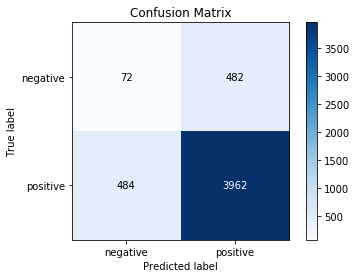

In [31]:
skplt.plot_confusion_matrix(y_ts,pred)

In [33]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.13      0.13      0.13       554
   positive       0.89      0.89      0.89      4446

avg / total       0.81      0.81      0.81      5000



optimal_k is:- 1


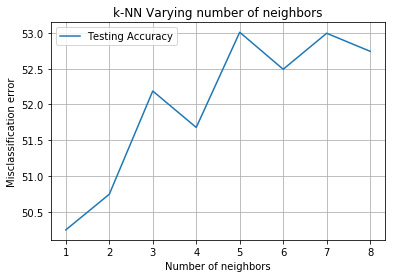

In [34]:
# Finding Optimal K by simple Cross validation¶ by brute algo 

optimal_k = find_optimal_k_brute(x_tr_dataset ,y_train,x_cv_dataset,y_cv)


In [35]:
from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)

# fitting the model
knn_optimal.fit(x_tr_dataset, y_train)

# predict the response
pred = knn_optimal.predict(x_ts_dataset)

# evaluate f1_score
f1_tfidf_brute = f1_score(y_ts, pred, average='macro') * float(100)
f1_tfidf_brute_optimal_k = optimal_k
print('\nThe f1_score of the knn classifier of brute algo for k = %d is %f%%' % (optimal_k, f1_tfidf_brute))


The accuracy of the knn classifier of brute algo for k = 1 is 51.053416%


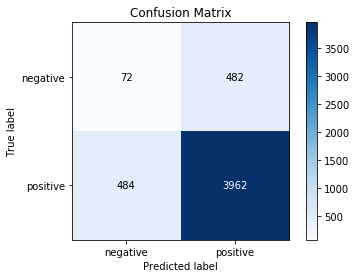

In [36]:
skplt.plot_confusion_matrix(y_ts ,pred)

In [37]:
#classification report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.13      0.13      0.13       554
   positive       0.89      0.89      0.89      4446

avg / total       0.81      0.81      0.81      5000



# [7.2.6] Word2Vec train data

In [38]:
# Word2Vec for train data
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in x_train['CleanedText'].values:
    list_of_sent.append(sent.split())

In [39]:
print(x_train['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [40]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5603
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'turn', 'whole', 'school', 'purchas', 'children']


In [42]:
w2v_model.wv.most_similar('tasti')

[('crunchi', 0.8753650188446045),
 ('satisfi', 0.8572958707809448),
 ('chewi', 0.8385087251663208),
 ('nutriti', 0.8355476260185242),
 ('crispi', 0.834044337272644),
 ('crisp', 0.8306637406349182),
 ('yummi', 0.8147004842758179),
 ('bombay', 0.8044424057006836),
 ('soft', 0.7914944291114807),
 ('crunch', 0.7907328605651855)]

In [43]:
w2v_model.wv.most_similar('like')

[('real', 0.8213435411453247),
 ('normal', 0.8042137622833252),
 ('prefer', 0.7925163507461548),
 ('isnt', 0.7837004661560059),
 ('think', 0.7791032791137695),
 ('bland', 0.7584354877471924),
 ('sort', 0.7490204572677612),
 ('weird', 0.7471733689308167),
 ('arent', 0.7392364740371704),
 ('horribl', 0.7285444140434265)]

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 15000/15000 [00:25<00:00, 580.79it/s]


15000
50


# Word2Vec for cv data

In [45]:
# Word2Vec
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_cv=[]
for sent in x_cv['CleanedText'].values:
    list_of_sent_cv.append(sent.split())

In [46]:
print(x_cv['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_cv[0])

realli good hot beverag tran fat havent tri ice would assum would also good way
*****************************************************************
['realli', 'good', 'hot', 'beverag', 'tran', 'fat', 'havent', 'tri', 'ice', 'would', 'assum', 'would', 'also', 'good', 'way']


In [47]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=4)

In [48]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2984
sample words  ['realli', 'good', 'hot', 'beverag', 'tran', 'fat', 'havent', 'tri', 'ice', 'would', 'assum', 'also', 'way', 'pretzel', 'think', 'box', 'could', 'pack', 'better', 'deliv', 'care', 'mani', 'broken', 'half', 'small', 'piec', 'two', 'plastic', 'partial', 'crush', 'bought', 'grandson', 'celiac', 'eat', 'absolut', 'delici', 'fool', 'friend', 'famili', 'tast', 'much', 'like', 'regular', 'wheat', 'pasta', 'store', 'wonder', 'great', 'product', 'recal']


In [49]:
w2v_model.wv.most_similar('tasti')

[('potato', 0.9988864660263062),
 ('crunchi', 0.9986565113067627),
 ('crispi', 0.9983552098274231),
 ('altern', 0.9982517957687378),
 ('nut', 0.9981160163879395),
 ('meal', 0.9980118274688721),
 ('chip', 0.9978975057601929),
 ('chewi', 0.9978684782981873),
 ('veggi', 0.9977338314056396),
 ('substitut', 0.9977049827575684)]

In [50]:
w2v_model.wv.most_similar('like')

[('tast', 0.9885746240615845),
 ('sweet', 0.9875316023826599),
 ('strong', 0.9857115149497986),
 ('bitter', 0.9854695796966553),
 ('realli', 0.983518660068512),
 ('chocol', 0.9810254573822021),
 ('light', 0.9804829359054565),
 ('hot', 0.9801589846611023),
 ('flavor', 0.9797714948654175),
 ('make', 0.9789963960647583)]

In [51]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 5000/5000 [00:05<00:00, 959.87it/s]


5000
50


# Word2Vec for test data

In [52]:
# Word2Vec
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_ts=[]
for sent in x_ts['CleanedText'].values:
    list_of_sent_ts.append(sent.split())

In [53]:
print(x_ts['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_ts[0])

german chocol tickl buy everi xmas smooth rich eleg arriv day thank
*****************************************************************
['german', 'chocol', 'tickl', 'buy', 'everi', 'xmas', 'smooth', 'rich', 'eleg', 'arriv', 'day', 'thank']


In [54]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent_ts,min_count=5,size=50, workers=4)

In [55]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2905
sample words  ['german', 'chocol', 'buy', 'everi', 'xmas', 'smooth', 'rich', 'eleg', 'arriv', 'day', 'thank', 'salt', 'separ', 'rice', 'someth', 'weird', 'happen', 'product', 'sit', 'top', 'tast', 'wick', 'terribl', 'either', 'folk', 'enjoy', 'dont', 'know', 'sushi', 'suppos', 'like', 'shipment', 'got', 'ruin', 'wont', 'order', 'ever', 'discov', 'sauc', 'restaur', 'search', 'everywher', 'garlic', 'avail', 'final', 'found', 'amazon', 'spici', 'doesnt', 'burn']


In [56]:
w2v_model.wv.most_similar('tasti')

[('crunch', 0.9992246627807617),
 ('creami', 0.9990120530128479),
 ('crunchi', 0.998974084854126),
 ('salti', 0.9989132285118103),
 ('salad', 0.9989044666290283),
 ('aftertast', 0.998854398727417),
 ('substitut', 0.9988285303115845),
 ('mapl', 0.998788595199585),
 ('toast', 0.9987733960151672),
 ('nut', 0.998724102973938)]

In [57]:
w2v_model.wv.most_similar('like')

[('tast', 0.9932795763015747),
 ('sweet', 0.9917718172073364),
 ('flavor', 0.9894028902053833),
 ('chocol', 0.9876375198364258),
 ('strong', 0.9838699102401733),
 ('hot', 0.9814661145210266),
 ('milk', 0.9799574017524719),
 ('bitter', 0.9756320714950562),
 ('dark', 0.9754601716995239),
 ('drink', 0.9754283428192139)]

In [58]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████| 5000/5000 [00:04<00:00, 1013.99it/s]


5000
50


In [59]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
x_tr_final_counts = model.fit_transform(x_train['CleanedText'].values)
x_cv_final_counts = model.fit_transform(x_cv['CleanedText'].values)
x_ts_final_counts = model.fit_transform(x_ts['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

print("the type of count vectorizer ",type(x_tr_final_counts))
print("the shape of out text TFIDF vectorizer ",x_tr_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_tr_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_cv_final_counts))
print("the shape of out text TFIDF vectorizer ",x_cv_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_cv_final_counts.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts))
print("the shape of out text TFIDF vectorizer ",x_ts_final_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_ts_final_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (15000, 16311)
the number of unique words including both unigrams and bigrams  16311
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 9086)
the number of unique words including both unigrams and bigrams  9086
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 8627)
the number of unique words including both unigrams and bigrams  8627


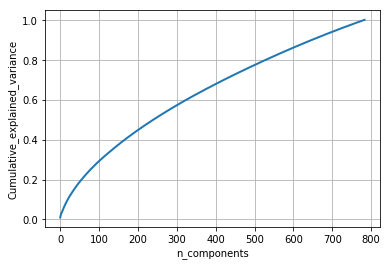

In [60]:
# dimenstionality reduction for word2vec train data
c = sc.fit_transform(x_tr_final_counts)
truncatesvd_reduction(c)

Here 500 components explain 80% of the variation in word2vec train data

In [61]:
svd = TruncatedSVD(n_components=500)
x_tr_dataset = svd.fit_transform(c)
x_tr_dataset.shape

(15000, 500)

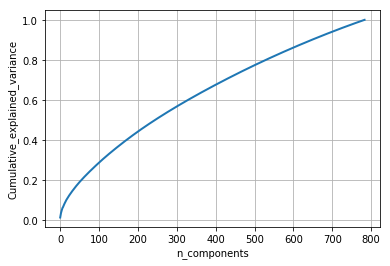

In [62]:
# dimenstionality reduction for word2vec cross validated data
c = sc.fit_transform(x_cv_final_counts)
truncatesvd_reduction(c)

Here 500 components explain 80% of the variation in word2vec cross validated data

In [63]:
svd = TruncatedSVD(n_components=500)
x_cv_dataset = svd.fit_transform(c)
x_cv_dataset.shape


(5000, 500)

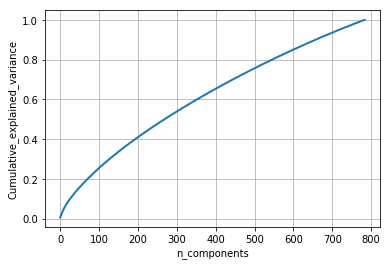

In [64]:
# dimenstionality reduction for word2vec test data
c = sc.fit_transform(x_ts_final_counts)
truncatesvd_reduction(c)


Here 500 components explain 80% of the variation in word2vec test data

In [65]:
svd = TruncatedSVD(n_components=500)
x_ts_dataset = svd.fit_transform(c)
x_ts_dataset.shape

(5000, 500)

In [66]:

print(x_tr_dataset.shape)
print(x_cv_dataset.shape)
print(x_ts_dataset.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_ts.shape)

(15000, 500)
(5000, 500)
(5000, 500)
(15000,)
(5000,)
(5000,)


optimal_k is:- 4


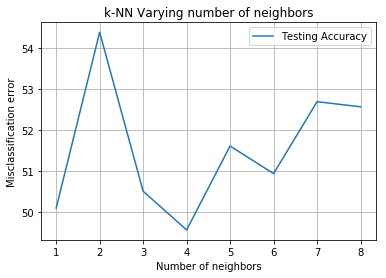

In [67]:
# Finding Optimal K by simple Cross validation¶ by kd- tree algo 


optimal_k = find_optimal_k_kdtree(x_tr_dataset,y_train,x_cv_dataset,y_cv)


In [68]:
from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)

# fitting the model
knn_optimal.fit(x_tr_dataset, y_train)

# predict the response
pred = knn_optimal.predict(x_ts_dataset)

# evaluate f1_score
f1_w2c_kdtree = f1_score(y_ts, pred, average='macro') * float(100)
f1_w2c_kdtree_optimal_k = optimal_k
print('\nThe f1_score of the knn classifier of KDtree algo for k = %d is %f%%' % (optimal_k, f1_w2c_kdtree))






The f1_score of the knn classifier of KDtree algo for k = 4 is 49.606452%


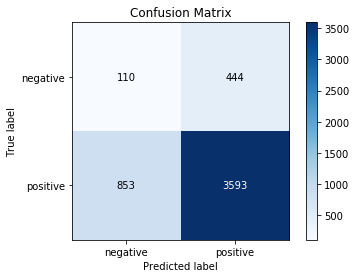

In [69]:
skplt.plot_confusion_matrix(y_ts,pred)


In [70]:
#classification report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.11      0.20      0.15       554
   positive       0.89      0.81      0.85      4446

avg / total       0.80      0.74      0.77      5000



optimal_k is:- 4


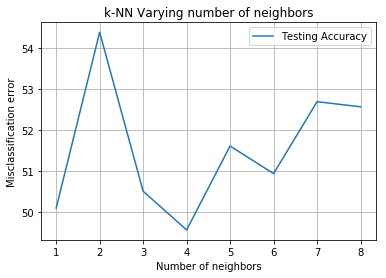

In [71]:
 # Finding Optimal K by simple Cross validation¶ by brute algo 

optimal_k = find_optimal_k_brute(x_tr_dataset ,y_train,x_cv_dataset,y_cv)



In [72]:

from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)

# fitting the model
knn_optimal.fit(x_tr_dataset, y_train)

# predict the response
pred = knn_optimal.predict(x_ts_dataset)

# evaluate accuracy
f1_w2c_brute = f1_score(y_ts, pred, average='macro') * float(100)
f1_w2c_brute_optimal_k = optimal_k
print('\nThe accuracy of the knn classifier of brute algo for k = %d is %f%%' % (optimal_k, f1_w2c_brute))





The accuracy of the knn classifier of brute algo for k = 4 is 49.606452%


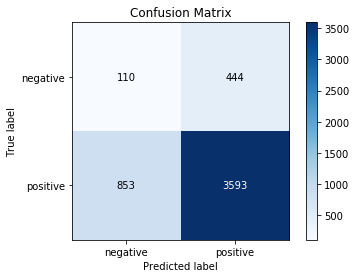

In [74]:

skplt.plot_confusion_matrix(y_ts ,pred)


In [75]:
#classification report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.11      0.20      0.15       554
   positive       0.89      0.81      0.85      4446

avg / total       0.80      0.74      0.77      5000



In [79]:
# TF-IDF weighted Word2Vec
#tfidf_feats = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 15000/15000 [00:23<00:00, 626.98it/s]


In [80]:
# TF-IDF weighted Word2Vec
#tfidf_feats = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 5000/5000 [00:07<00:00, 681.29it/s]


In [81]:
# TF-IDF weighted Word2Vec
#tfidf_feats = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors2.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 5000/5000 [00:07<00:00, 706.43it/s]


In [82]:
x_tr_final_counts =  tfidf_sent_vectors
x_cv_final_counts = tfidf_sent_vectors1
x_ts_final_counts = tfidf_sent_vectors2


optimal_k is:- 1


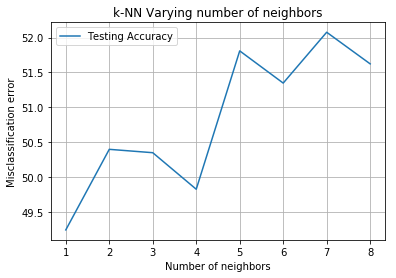

In [83]:
# Finding Optimal K by simple Cross validation¶ by kd- tree algo 

optimal_k = find_optimal_k_kdtree(x_tr_final_counts,y_train,x_cv_final_counts,y_cv)


In [84]:
from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)

# fitting the model
knn_optimal.fit(x_tr_final_counts, y_train)

# predict the response
pred = knn_optimal.predict(x_ts_final_counts)

# evaluate accuracy
f1_tfidf_w2c_kdtree = f1_score(y_ts, pred, average='macro') * float(100)
f1_tfidf_w2c_kdtree_optimal_k = optimal_k
print('\nThe accuracy of the knn classifier of KDtree algo for k = %d is %f%%' % (optimal_k, f1_tfidf_w2c_kdtree))





The accuracy of the knn classifier of KDtree algo for k = 1 is 48.942989%


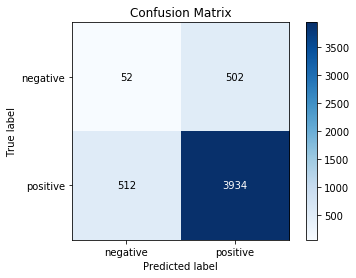

In [86]:
skplt.plot_confusion_matrix(y_ts ,pred)

In [87]:
#classification report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.09      0.09      0.09       554
   positive       0.89      0.88      0.89      4446

avg / total       0.80      0.80      0.80      5000



optimal_k is:- 1


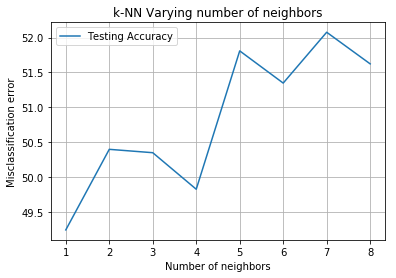

In [89]:
# Finding Optimal K by simple Cross validation¶ by brute algo 

optimal_k = find_optimal_k_brute(x_tr_final_counts,y_train,x_cv_final_counts,y_cv)


In [91]:
from sklearn.metrics import f1_score
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k)

# fitting the model
knn_optimal.fit(x_tr_final_counts, y_train)

# predict the response
pred = knn_optimal.predict(x_ts_final_counts)

# evaluate accuracy
f1_tfidf_w2c_brute = f1_score(y_ts, pred, average='macro') * float(100)
f1_tfidf_w2c_brute_optimal_k = optimal_k
print('\nThe accuracy of the knn classifier of brute algo for k = %d is %f%%' % (optimal_k, f1_tfidf_w2c_brute))


The accuracy of the knn classifier of brute algo for k = 1 is 48.942989%


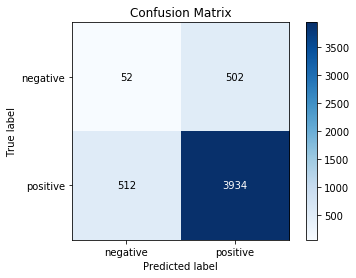

In [92]:
skplt.plot_confusion_matrix(y_ts ,pred)

In [93]:
#classification report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

   negative       0.09      0.09      0.09       554
   positive       0.89      0.88      0.89      4446

avg / total       0.80      0.80      0.80      5000



In [100]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model","hyperparameter(k)","F1_Score"]
x.add_row(["BOW","KD-Tree",f1_bowt_kdtree_optimal_k,f1_bowt_kdtree])
x.add_row(["BOW","Brute",f1_bowt_brute_optimal_k,f1_bowt_brute])
x.add_row(["TF-IDF","KD-Tree",f1_tfidf_kdtree_optimal_k,f1_tfidf_kdtree])
x.add_row(["TF-IDF","Brute",f1_tfidf_brute_optimal_k,f1_tfidf_brute])
x.add_row(["Word2Vec","KD-Tree",f1_w2c_kdtree_optimal_k,f1_w2c_kdtree])
x.add_row(["Word2Vec","Brute",f1_w2c_brute_optimal_k,f1_w2c_brute])
x.add_row([" TFIDF Word2Vec","KD-Tree",f1_tfidf_w2c_kdtree_optimal_k,f1_tfidf_w2c_kdtree])
x.add_row(["TFIDF Word2Vec","Brute",f1_tfidf_w2c_brute_optimal_k,f1_tfidf_w2c_brute])
print(x)

+-----------------+---------+-------------------+--------------------+
|    Vectorizer   |  Model  | hyperparameter(k) |      F1_Score      |
+-----------------+---------+-------------------+--------------------+
|       BOW       | KD-Tree |         2         |     50.761934      |
|       BOW       |  Brute  |         2         |     50.761934      |
|      TF-IDF     | KD-Tree |         1         | 51.053415620344744 |
|      TF-IDF     |  Brute  |         1         | 51.053415620344744 |
|     Word2Vec    | KD-Tree |         4         | 49.60645242557704  |
|     Word2Vec    |  Brute  |         4         | 49.60645242557704  |
|  TFIDF Word2Vec | KD-Tree |         1         | 48.942988955975764 |
|  TFIDF Word2Vec |  Brute  |         1         | 48.942988955975764 |
+-----------------+---------+-------------------+--------------------+


As per the above chart observation, "word2vec KD-tree" and "word2vec Brute" is well fit. others Bow , TF-IDF and TFIDF word2vec models are underfit. so we will consider "Word2vec KD-tree" and "Word2vec brute" model for classification positve and negative datapoints with hyperparameter 4.  